In [1]:
import sys
import pandas as pd
import numpy as np
import tensorflow as tf
import sklearn as sk
from pickle import dump

from tensorflow import keras
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras import backend as K
from tensorflow.python.client import device_lib

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns

print(f"Python {sys.version}")
print()
print(f"Pandas {pd.__version__}")
print(f"Tensorflow {tf.__version__}")
print(f"Keras {keras.__version__}")
print(f"SciKit Learn {sk.__version__}")
print()

devices = device_lib.list_local_devices()

if 'GPU' in ('').join(str(devices)):
    print("tf accessable GPU found: "+devices[-2].physical_device_desc)

Python 3.7.7 (default, Mar 23 2020, 22:36:06) 
[GCC 7.3.0]

Pandas 1.0.3
Tensorflow 2.1.0
Keras 2.2.4-tf
SciKit Learn 0.22.1

tf accessable GPU found: device: 0, name: GeForce GTX 1070, pci bus id: 0000:02:00.0, compute capability: 6.1


**Data manipulation functions**

In [2]:
def format_features_labels_for_LSTM(
    dataframe,            # incomming_data
#    target_column_index,  # index of column with labels
    history_size,         # size of past history time chunk
    target_size,          # number of timepoints to predict from each history time chunk
    step                  # number of timepoints to move the history time chunk as we 
                          # slide over the data
):
    
    '''takes dataframe and information about desired output shape (history window size, 
    target window size, timesteps to slide history window) and returns two formatted
    lists: one for features and one for labels'''

    data = []
    labels = []
    
    # break dataframe into spatial bins by lat lon
    spatial_bins = dataframe.groupby(['lat', 'lon'])
    
    # loop on spatial bins and split each into test and training 
    # sets 
    for bin_name, spatial_bin in spatial_bins:
        
        # sort bin by date, then drop date column
        spatial_bin = spatial_bin.sort_values('date')
        spatial_bin.drop('date', axis=1, inplace=True)
        
        # get index of ignition column
        ignition_index = spatial_bin.columns.get_loc('ignition')
        
        # convert to numpy array
        spatial_bin = np.array(spatial_bin.values)
        
        # split ignition label off
        target = spatial_bin[:, ignition_index]
        spatial_bin = np.delete(spatial_bin, ignition_index, 1)
        
        bin_data = []
        bin_labels = []
    
        # set start and end - note: some trimming is 
        # necessary here so that the target (in the future)
        # does not slide off the end of the array as we
        # move the history window forward
        start_index = history_size
        end_index = len(spatial_bin) - target_size

        # loop over the history window in steps of step size
        # grab a time block of data with length history_size
        # and the corresponding labels
        for i in range(start_index, end_index):
            indices = range(i - history_size, i, step)
            bin_data.append(spatial_bin[indices])
            bin_labels.append(target[i + target_size])

        # add to master
        data.append(np.array(bin_data))
        labels.append(np.array(bin_labels))

    return data, labels


def trim_and_reshape_for_LSTM(x, y):
    '''Trim the number of samples in each bin so that they are all the same.
    at the same time, reshape y so that it's first axis is the number of samples
    and the second is number of spatial bins'''
    
    sample_sizes = []

    for sample in y:
        sample_sizes.append(len(sample))

    smallest_sample = min(sample_sizes)

    y_reshaped = []

    for i in range(smallest_sample):
        new_y = []
        for j in range(len(y)):
            try:
                new_y.append(y[j][i])
            except:
                print("Index out of range")

        y_reshaped.append(np.array(new_y))

    trimmed_x = []    

    for sample in x:
        trimmed_sample = sample[-smallest_sample:,:]
        trimmed_x.append(trimmed_sample)
        
        
    return trimmed_x, y_reshaped

def weighted_bce(class_0_weight, class_1_weight):
    def loss(y_true, y_pred):
        return K.mean(K.binary_crossentropy(y_true, y_pred) * ((y_true * class_1_weight) + class_0_weight))
    
    return loss

**Plotting functions**

In [3]:
def one_sample_density_plot(
    plot_location, 
    data, 
    #normalized_data, 
    data_type, 
    title, 
    xlabel, 
    ylabel, 
):
    values, base = np.histogram(data[data_type], bins=40)

    ax[plot_location].plot(base[:-1], (values/len(data)))
    ax[plot_location].tick_params(labelsize=12)
    ax[plot_location].set_title(title, fontsize=18)
    ax[plot_location].set_xlabel(xlabel, fontsize=14)
    ax[plot_location].set_ylabel(ylabel, fontsize=15)
    ax[plot_location].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

def three_sample_density_plot(
    plot_location, 
    sample_1_data,
    sample_2_data,
    sample_3_data,
    data_type, 
    title, 
    xlabel, 
    ylabel, 
):
    sample_1_values, sample_1_base = np.histogram(sample_1_data[data_type], bins=40)
    sample_2_values, sample_2_base = np.histogram(sample_2_data[data_type], bins=40)
    sample_3_values, sample_3_base = np.histogram(sample_3_data[data_type], bins=40)

    ax[plot_location].plot(sample_1_base[:-1], (sample_1_values/len(sample_1_data)))
    ax[plot_location].plot(sample_2_base[:-1], (sample_2_values/len(sample_2_data)))
    ax[plot_location].plot(sample_3_base[:-1], (sample_3_values/len(sample_1_data)))
    ax[plot_location].tick_params(labelsize=12)
    ax[plot_location].set_title(title, fontsize=18)
    ax[plot_location].set_xlabel(xlabel, fontsize=14)
    ax[plot_location].set_ylabel(ylabel, fontsize=15)
    ax[plot_location].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    
def plot_metrics(history, metrics, filename):
    '''takes history from model.fit() keras call, training metrics of intrest and filename.
    plots training metrics over time and saves .png figuresd to filename'''
    
    plt.subplots(2, 3, figsize=(10.5, 7.0))
    count_based_metrics = {'true_positives', 'true_negatives', 'false_positives', 'false_negatives'}
    
    # loop on metrics to make plots
    for n, metric in enumerate(metrics):
        name = metric.replace("_", " ").capitalize()
        plt.subplot(2, 3, n + 1)
        plt.plot(history.epoch, history.history[metric], color = 'royalblue', label = 'Train')
        plt.plot(history.epoch, history.history['val_' + metric],
             color = 'royalblue', linestyle = "--", label = 'Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        plt.title(name)
    
    plt.legend()
    plt.tight_layout()
    plt.savefig(filename, bbox_inches='tight')
    
def plot_cm(labels, predictions, p=0.1):
    cm = confusion_matrix(labels, predictions > p)
    normalized_cm = np.empty([2, 2])
    normalized_cm[0][0] = cm[0][0] / (cm[0][0] + cm[0][1])
    normalized_cm[0][1] = cm[0][1] / (cm[0][0] + cm[0][1])
    normalized_cm[1][0] = cm[1][0] / (cm[1][0] + cm[1][1])
    normalized_cm[1][1] = cm[1][1] / (cm[1][0] + cm[1][1])
    plt.figure(figsize=(5,5))
    sns.heatmap(normalized_cm, annot=True)
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('No fire (True Negatives): ', cm[0][0])
    print('False alarms (False Positives): ', cm[0][1])
    print('Fires missed (False Negatives): ', cm[1][0])
    print('Fires detected (True Positives): ', cm[1][1])
    print('Total fires: ', np.sum(cm[1]))
    
    plt.tight_layout()
    plt.savefig('../project_info/figures/parallel_statefull_LSTM_confusion_matrix_CA_only.png', bbox_inches='tight')


In [4]:
data_file = '/mnt/SSD/data/training_data/1992-2015_california_features_added.parquet'

In [5]:
# Features to use during training 
features = [
    'lat',
    'lon',
    'mean_air_2m',
    'mean_apcp',
    'mean_rhum_2m',
    'mean_dpt_2m',
    'mean_pres_sfc',
    'mean_uwnd_10m',
    'mean_vwnd_10m',
    'mean_cloud_cover',
    'ignition',
    'date'
]

features_to_scale = [
    'mean_air_2m',
    'mean_apcp',
    'mean_rhum_2m',
    'mean_dpt_2m',
    'mean_pres_sfc',
    'mean_uwnd_10m',
    'mean_vwnd_10m',
    'mean_cloud_cover',
]

In [6]:
# read data and grab features of intrest
raw_data = pd.read_parquet(data_file)
data = raw_data[features]

In [7]:
num_fires = data['ignition'].sum()
total_observations = len(data)

In [8]:
# One hot encode month
month_names = [
    'January',
    'February',
    'March',
    'April',
    'May',
    'June',
    'July',
    'August',
    'September',
    'October',
    'November',
    'December'
]


onehot_encoder = OneHotEncoder(sparse=False)

# get months from each row of data, reshape from wide to long
month = np.array(pd.DatetimeIndex(data['date']).month).reshape(-1, 1)

# onehot encode
onehot_month = onehot_encoder.fit_transform(month)

# convert to pandas dataframe with named columns
onehot_month_df = pd.DataFrame(onehot_month, columns=month_names)

# set type to int
onehot_month_df = onehot_month_df.astype('int32')

# reset indexes
onehot_month_df.reset_index(drop=True, inplace=True)
data.reset_index(drop=True, inplace=True)

# join months back to data along rows
data = pd.concat([data, onehot_month_df], axis=1)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3594060 entries, 0 to 3594059
Data columns (total 24 columns):
 #   Column            Dtype         
---  ------            -----         
 0   lat               float32       
 1   lon               float32       
 2   mean_air_2m       float32       
 3   mean_apcp         float32       
 4   mean_rhum_2m      float32       
 5   mean_dpt_2m       float32       
 6   mean_pres_sfc     float32       
 7   mean_uwnd_10m     float32       
 8   mean_vwnd_10m     float32       
 9   mean_cloud_cover  float32       
 10  ignition          float32       
 11  date              datetime64[ns]
 12  January           int32         
 13  February          int32         
 14  March             int32         
 15  April             int32         
 16  May               int32         
 17  June              int32         
 18  July              int32         
 19  August            int32         
 20  September         int32         
 21  October 

In [10]:
data.describe()

,lat,lon,mean_air_2m,mean_apcp,mean_rhum_2m,mean_dpt_2m,mean_pres_sfc,mean_uwnd_10m,mean_vwnd_10m,mean_cloud_cover,...,March,April,May,June,July,August,September,October,November,December
count,3.594060e+06,3.594060e+06,3.594060e+06,3.594060e+06,3.594060e+06,3.594060e+06,3.594060e+06,3.594060e+06,3.594060e+06,3.594060e+06,...,3.594060e+06,3.594060e+06,3.594060e+06,3.594060e+06,3.594060e+06,3.594060e+06,3.594060e+06,3.594060e+06,3.594060e+06,3.594060e+06
mean,3.712057e+01,-1.195196e+02,2.879437e+02,1.747614e-01,4.925318e+01,2.747232e+02,9.152797e+04,1.055435e+00,1.629883e-01,1.467851e+01,...,8.487337e-02,8.213552e-02,8.487337e-02,8.213552e-02,8.487337e-02,8.487337e-02,8.213552e-02,8.487337e-02,8.213552e-02,8.487337e-02
std,2.555418e+00,2.505702e+00,9.140187e+00,6.408220e-01,2.339893e+01,6.993439e+00,6.966659e+03,2.170170e+00,2.827547e+00,1.847955e+01,...,2.786932e-01,2.745711e-01,2.786932e-01,2.745711e-01,2.786932e-01,2.786932e-01,2.745711e-01,2.786932e-01,2.745711e-01,2.786932e-01
min,3.268389e+01,-1.243408e+02,2.504765e+02,0.000000e+00,1.478230e+00,2.298151e+02,6.661040e+04,-1.733236e+01,-1.718333e+01,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.499029e+01,-1.214709e+02,2.816839e+02,9.497930e-05,2.927946e+01,2.700092e+02,8.715124e+04,-3.261476e-01,-1.679754e+00,1.572917e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,3.681598e+01,-1.198972e+02,2.873206e+02,7.324219e-04,4.673757e+01,2.752203e+02,9.231579e+04,1.041583e+00,1.428150e-01,6.494792e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,3.925970e+01,-1.174117e+02,2.942778e+02,2.111294e-02,6.864366e+01,2.799445e+02,9.708966e+04,2.392024e+00,2.011975e+00,2.136979e+01,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,4.197182e+01,-1.143645e+02,3.153345e+02,2.093382e+01,9.999260e+01,2.967875e+02,1.032571e+05,1.752185e+01,2.345413e+01,9.964584e+01,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [11]:
qt = QuantileTransformer(random_state = 0, output_distribution = 'normal')
normalized_data = pd.DataFrame(qt.fit_transform(data[features_to_scale]), columns=features_to_scale)
data[features_to_scale] = normalized_data
dump(qt, open('./data_transformations/quantile_transformer', 'wb'))

scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_features = scaler.fit_transform(data[features_to_scale])
data[features_to_scale] = scaled_features
dump(scaler, open('./data_transformations/min_max_scaler', 'wb'))

data[features_to_scale] = data[features_to_scale].astype('float32')

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3594060 entries, 0 to 3594059
Data columns (total 24 columns):
 #   Column            Dtype         
---  ------            -----         
 0   lat               float32       
 1   lon               float32       
 2   mean_air_2m       float32       
 3   mean_apcp         float32       
 4   mean_rhum_2m      float32       
 5   mean_dpt_2m       float32       
 6   mean_pres_sfc     float32       
 7   mean_uwnd_10m     float32       
 8   mean_vwnd_10m     float32       
 9   mean_cloud_cover  float32       
 10  ignition          float32       
 11  date              datetime64[ns]
 12  January           int32         
 13  February          int32         
 14  March             int32         
 15  April             int32         
 16  May               int32         
 17  June              int32         
 18  July              int32         
 19  August            int32         
 20  September         int32         
 21  October 

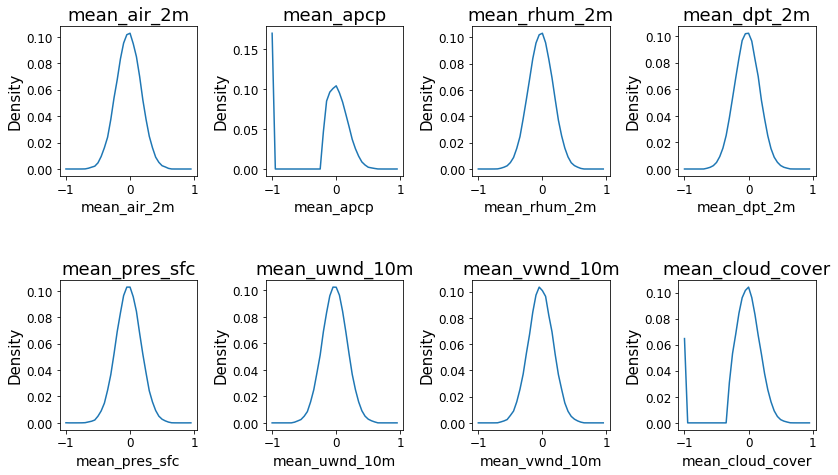

In [13]:
# Distribution plotting variables

left  = 0.125  # the left side of the subplots of the figure
right = 0.65   # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.5   # the amount of width reserved for blank space between subplots
hspace = 0.7   # the amount of height reserved for white space between subplots

fig_rows = 2
fig_cols = 4
plot_height = 7
plot_width = 20

plot_locations = [
    (0,0),(0,1),(0,2),(0,3),
    (1,0),(1,1),(1,2),(1,3)
]

xlabels = features_to_scale
ylabels = ['Density'] * len(features_to_scale)

# Make density plots
fig, ax = plt.subplots(fig_rows, fig_cols, figsize=(plot_width, plot_height))
fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

for i in range(len(plot_locations)):
    ax[plot_locations[i]] = one_sample_density_plot(
        plot_locations[i], 
        data, 
        features_to_scale[i], 
        features_to_scale[i], 
        features_to_scale[i], 
        ylabels[i]
    )
    
plt.show()

In [14]:
# make sure data is sorted by date, then drop date column
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')
data = data.sort_index()
data.reset_index(inplace=True)#, drop=True)

# set datetime index
# data.set_index(pd.DatetimeIndex(data['date']), inplace=True)
# data.drop('date', axis=1, inplace=True)

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3594060 entries, 0 to 3594059
Data columns (total 24 columns):
 #   Column            Dtype         
---  ------            -----         
 0   date              datetime64[ns]
 1   lat               float32       
 2   lon               float32       
 3   mean_air_2m       float32       
 4   mean_apcp         float32       
 5   mean_rhum_2m      float32       
 6   mean_dpt_2m       float32       
 7   mean_pres_sfc     float32       
 8   mean_uwnd_10m     float32       
 9   mean_vwnd_10m     float32       
 10  mean_cloud_cover  float32       
 11  ignition          float32       
 12  January           int32         
 13  February          int32         
 14  March             int32         
 15  April             int32         
 16  May               int32         
 17  June              int32         
 18  July              int32         
 19  August            int32         
 20  September         int32         
 21  October 

In [16]:
# Split data up into training, testing and validation sets
testing_data = data.tail(int(len(data) * 0.25))
leftover_data = data.head(int(len(data) * 0.75))
validation_data = data.tail(int(len(leftover_data) * 0.5))
training_data = data.head(int(len(leftover_data) * 0.5))

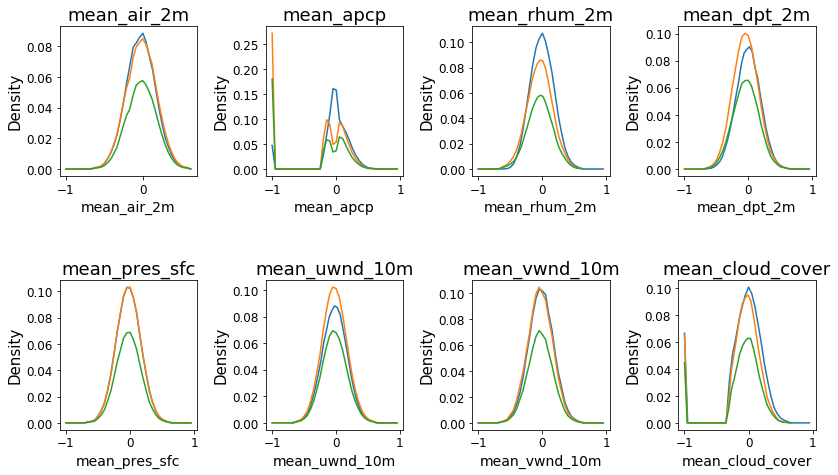

In [17]:
# Distribution plotting variables

left  = 0.125  # the left side of the subplots of the figure
right = 0.65   # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.5   # the amount of width reserved for blank space between subplots
hspace = 0.7   # the amount of height reserved for white space between subplots

fig_rows = 2
fig_cols = 4
plot_height = 7
plot_width = 20

plot_locations = [
    (0,0),(0,1),(0,2),(0,3),
    (1,0),(1,1),(1,2),(1,3)
]

xlabels = features_to_scale
ylabels = ['Density'] * len(features_to_scale)

# Make density plots
fig, ax = plt.subplots(fig_rows, fig_cols, figsize=(plot_width, plot_height))
fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

for i in range(len(plot_locations)):
    ax[plot_locations[i]] = three_sample_density_plot(
        plot_locations[i], 
        training_data, 
        validation_data, 
        testing_data, 
        features_to_scale[i], 
        features_to_scale[i], 
        features_to_scale[i], 
        ylabels[i]
    )
    
plt.show()

In [18]:
num_fires = data['ignition'].sum()
total_observations = len(data)

print("Fires observed: {}".format(num_fires))
print("Total observations: {}".format(total_observations))
print()
print("Training data: {} observations".format(len(training_data)))
print("Validation data: {} observations".format(len(validation_data)))
print("Testing data: {} observations".format(len(testing_data)))

Fires observed: 231024.0
Total observations: 3594060

Training data: 1347772 observations
Validation data: 1347772 observations
Testing data: 898515 observations


In [19]:
# Split data into 410 member lists, one element for each geospatial bin (and network input)
# each element of the list contains samples with a duration of past_history

past_history = 5
future_target = 1
step = 1

x_training, y_training = format_features_labels_for_LSTM(
    training_data,        # incomming_data
    past_history,         # size of past history time chunk
    future_target,        # number of future timepoints to predict from each history time chunk
    step,                 # number of timepoints to move the history time chunk as we slide over the data
)

x_validation, y_validation = format_features_labels_for_LSTM(
    validation_data,      # incomming_data
    past_history,         # size of past history time chun
    future_target,        # number of future timepoints to predict from each history time chunk
    step,                 # number of timepoints to move the history time chunk as we slide over the data
)

x_testing, y_testing = format_features_labels_for_LSTM(
    testing_data,         # incomming_data
    past_history,         # size of past history time chun
    future_target,        # number of future timepoints to predict from each history time chunk
    step,                 # number of timepoints to move the history time chunk as we slide over the data
)

In [20]:
print("x_training is {}, length: {}, member shape: {}.".format(type(x_training), len(x_training), x_training[0].shape))
print("y_training is {}, length: {}, member shape: {}.".format(type(y_training), len(y_training), y_training[0].shape))
print()
print("x_validation is {}, length: {}, member shape: {}.".format(type(x_validation), len(x_validation), x_validation[0].shape))
print("y_validation is {}, length: {}, member shape: {}.".format(type(y_validation), len(y_validation), y_validation[0].shape))
print()
print("x_testing is {}, length: {}, member shape: {}.".format(type(x_testing), len(x_testing), x_testing[0].shape))
print("y_testing is {}, length: {}, member shape: {}.".format(type(y_testing), len(y_testing), y_testing[0].shape))

x_training is <class 'list'>, length: 410, member shape: (3281, 5, 22).
y_training is <class 'list'>, length: 410, member shape: (3281,).

x_validation is <class 'list'>, length: 410, member shape: (3281, 5, 22).
y_validation is <class 'list'>, length: 410, member shape: (3281,).

x_testing is <class 'list'>, length: 410, member shape: (2186, 5, 22).
y_testing is <class 'list'>, length: 410, member shape: (2186,).


In [21]:
x_training, y_training = trim_and_reshape_for_LSTM(x_training, y_training)
x_validation, y_validation = trim_and_reshape_for_LSTM(x_validation, y_validation)
x_testing, y_testing = trim_and_reshape_for_LSTM(x_testing, y_testing)

In [22]:
print("x_training is {}, length: {}, member shape: {}.".format(type(x_training), len(x_training), x_training[0].shape))
print("y_training is {}, length: {}, member shape: {}.".format(type(y_training), len(y_training), y_training[0].shape))
print()
print("x_validation is {}, length: {}, member shape: {}.".format(type(x_validation), len(x_validation), x_validation[0].shape))
print("y_validation is {}, length: {}, member shape: {}.".format(type(y_validation), len(y_validation), y_validation[0].shape))
print()
print("x_testing is {}, length: {}, member shape: {}.".format(type(x_testing), len(x_testing), x_testing[0].shape))
print("y_testing is {}, length: {}, member shape: {}.".format(type(y_testing), len(y_testing), y_testing[0].shape))

x_training is <class 'list'>, length: 410, member shape: (3281, 5, 22).
y_training is <class 'list'>, length: 3281, member shape: (410,).

x_validation is <class 'list'>, length: 410, member shape: (3281, 5, 22).
y_validation is <class 'list'>, length: 3281, member shape: (410,).

x_testing is <class 'list'>, length: 410, member shape: (2185, 5, 22).
y_testing is <class 'list'>, length: 2185, member shape: (410,).


In [23]:
# Trim each sample again to be a multiple of the batch size so we
# can do minibatch gradient descent - Note: this is required for statefull LSTMs

BATCH_SIZE = 100

for i in range(len(x_training)):
    start_index = (x_training[i].shape[0] - (x_training[i].shape[0] % BATCH_SIZE))
    end_index = x_training[i].shape[0]

    x_training[i] = np.delete(x_training[i], range(start_index, end_index), axis=0)

y_training = np.delete(y_training, range(start_index, end_index), axis=0)

for i in range(len(x_validation)):
    start_index = (x_validation[i].shape[0] - (x_validation[i].shape[0] % BATCH_SIZE))
    end_index = x_validation[i].shape[0]

    x_validation[i] = np.delete(x_validation[i], range(start_index, end_index), axis=0)

y_validation = np.delete(y_validation, range(start_index, end_index), axis=0)

for i in range(len(x_testing)):
    start_index = (x_testing[i].shape[0] - (x_testing[i].shape[0] % BATCH_SIZE))
    end_index = x_testing[i].shape[0]

    x_testing[i] = np.delete(x_testing[i], range(start_index, end_index), axis=0)

y_testing = np.delete(y_testing, range(start_index, end_index), axis=0)

In [24]:
print("x_training is {}, length: {}, member shape: {}.".format(type(x_training), len(x_training), x_training[0].shape))
print("y_training is {}, length: {}, member shape: {}.".format(type(y_training), len(y_training), y_training[0].shape))
print()
print("x_validation is {}, length: {}, member shape: {}.".format(type(x_validation), len(x_validation), x_validation[0].shape))
print("y_validation is {}, length: {}, member shape: {}.".format(type(y_validation), len(y_validation), y_validation[0].shape))
print()
print("x_testing is {}, length: {}, member shape: {}.".format(type(x_testing), len(x_testing), x_testing[0].shape))
print("y_testing is {}, length: {}, member shape: {}.".format(type(y_testing), len(y_testing), y_testing[0].shape))

x_training is <class 'list'>, length: 410, member shape: (3200, 5, 22).
y_training is <class 'numpy.ndarray'>, length: 3200, member shape: (410,).

x_validation is <class 'list'>, length: 410, member shape: (3200, 5, 22).
y_validation is <class 'numpy.ndarray'>, length: 3200, member shape: (410,).

x_testing is <class 'list'>, length: 410, member shape: (2100, 5, 22).
y_testing is <class 'numpy.ndarray'>, length: 2100, member shape: (410,).


In [25]:
# hyperparameters (adapted from single LSTM Cassandra model)

learning_rate = 0.001
parallel_lstm_units = 50
lstm_units = 410 * 5
hidden_units = 410 * 5
hidden_l1_lambda = 0.1
variational_dropout = 0.24

# class_0_weight = (1 / (total_observations - num_fires))*(total_observations)/2.0 
# class_1_weight = ((1 / num_fires)*(total_observations)/2.0)#*0.8

class_0_weight = 1
class_1_weight = 1

raw_output_bias = np.log([num_fires/(total_observations - num_fires)])[0]
output_bias = tf.keras.initializers.Constant(raw_output_bias)

print(f'Inital output bias: {raw_output_bias}')
print(f'Class 0 weight: {class_0_weight}')
print(f'Class 1 weight: {class_1_weight}')


metrics = [
    tf.keras.metrics.TruePositives(thresholds = 0.1, name = "true_positives"),
    tf.keras.metrics.FalsePositives(thresholds = 0.1, name = "false_positives"),
    tf.keras.metrics.TrueNegatives(thresholds = 0.1, name = "true_negatives"),
    tf.keras.metrics.FalseNegatives(thresholds = 0.1, name = "false_negatives"),
    tf.keras.metrics.Precision(thresholds = 0.1, name = "precision"), # TP / (TP + FP)
    tf.keras.metrics.Recall(thresholds = 0.1, name = "recall"),        # TP / (TP + FN)
]

Inital output bias: -2.6780778151820326
Class 0 weight: 1
Class 1 weight: 1


In [26]:
inputs = []
LSTMs = []

for i in range(len(x_training)):
    inputs.append(
        keras.Input(
            batch_shape=(
                BATCH_SIZE,
                x_training[0].shape[1],
                x_training[0].shape[2]
            )
        )
    )
    
for i in range(len(x_training)):
    LSTMs.append(keras.layers.LSTM(
        parallel_lstm_units,
        dropout = variational_dropout,
        stateful = True,
        return_sequences = True
    )(inputs[i]))
    
merged = keras.layers.concatenate(LSTMs)

lstm1 = keras.layers.LSTM(
    lstm_units,
    dropout = variational_dropout,
    stateful = True
)(merged)

hidden1 = keras.layers.Dense(
    hidden_units,
    kernel_regularizer=keras.regularizers.l1(hidden_l1_lambda),
    bias_initializer=tf.keras.initializers.he_normal(),
    activation = 'relu'
)(lstm1)

hidden2 = keras.layers.Dense(
    (hidden_units // 2),
    kernel_regularizer=keras.regularizers.l1(hidden_l1_lambda),
    bias_initializer=tf.keras.initializers.he_normal(),
    activation = 'relu'
)(hidden1)

hidden3 = keras.layers.Dense(
    (hidden_units // 3),
    kernel_regularizer=keras.regularizers.l1(hidden_l1_lambda),
    bias_initializer=tf.keras.initializers.he_normal(),
    activation = 'relu'
)(hidden2)

output = keras.layers.Dense(
    410,
    activation = 'sigmoid',
    bias_initializer = output_bias
)(hidden2)

model = keras.Model(inputs=inputs, outputs=output)

model.compile(
    optimizer=tf.keras.optimizers.Adam(lr = learning_rate),
    loss = weighted_bce(class_0_weight, class_1_weight),
    metrics = metrics
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(100, 5, 22)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(100, 5, 22)]       0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(100, 5, 22)]       0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(100, 5, 22)]       0                                            
______________________________________________________________________________________________

lstm_102 (LSTM)                 (100, 5, 50)         14600       input_103[0][0]                  
__________________________________________________________________________________________________
lstm_103 (LSTM)                 (100, 5, 50)         14600       input_104[0][0]                  
__________________________________________________________________________________________________
lstm_104 (LSTM)                 (100, 5, 50)         14600       input_105[0][0]                  
__________________________________________________________________________________________________
lstm_105 (LSTM)                 (100, 5, 50)         14600       input_106[0][0]                  
__________________________________________________________________________________________________
lstm_106 (LSTM)                 (100, 5, 50)         14600       input_107[0][0]                  
__________________________________________________________________________________________________
lstm_107 (

                                                                 lstm_201[0][0]                   
                                                                 lstm_202[0][0]                   
                                                                 lstm_203[0][0]                   
                                                                 lstm_204[0][0]                   
                                                                 lstm_205[0][0]                   
                                                                 lstm_206[0][0]                   
                                                                 lstm_207[0][0]                   
                                                                 lstm_208[0][0]                   
                                                                 lstm_209[0][0]                   
                                                                 lstm_210[0][0]                   
          

In [27]:
STEPS_PER_EPOCH = (x_training[0].shape[0] * 0.99) // BATCH_SIZE
VALIDATION_STEPS = (x_validation[0].shape[0] * 0.99) // BATCH_SIZE

# Use early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=0,
    patience=10,
    mode='max',
    restore_best_weights=True
)

history = model.fit(
    x_training, 
    y_training,
    batch_size = BATCH_SIZE, 
    epochs = 40,
    steps_per_epoch = STEPS_PER_EPOCH,
    validation_steps = VALIDATION_STEPS,
    validation_data = (x_validation, y_validation),
    workers = 8
)

Train on 3200 samples, validate on 3200 samples
Epoch 1/40
3100/3200 [============================>.] - ETA: 1s - loss: 78.7267 - true_positives: 69834.0000 - false_positives: 485066.0000 - true_negatives: 701419.0000 - false_negatives: 14681.0000 - precision: 0.1258 - recall: 0.8263 - val_loss: 77.3288 - val_true_positives: 65205.0000 - val_false_positives: 477295.0000 - val_true_negatives: 712267.0000 - val_false_negatives: 16233.0000 - val_precision: 0.1202 - val_recall: 0.8007Epoch 19/40


3100/3200 [============================>.] - ETA: 1s - loss: 78.7421 - true_positives: 69367.0000 - false_positives: 475933.0000 - true_negatives: 710660.0000 - false_negatives: 15040.0000 - precision: 0.1272 - recall: 0.8218 - val_loss: 76.5482 - val_true_positives: 66340.0000 - val_false_positives: 494760.0000 - val_true_negatives: 694802.0000 - val_false_negatives: 15098.0000 - val_precision: 0.1182 - val_recall: 0.8146Epoch 37/40


3100/3200 [============================>.] - ETA: 1s - loss: 78.6536 - true_positives: 68409.0000 - false_positives: 481391.0000 - true_negatives: 706854.0000 - false_negatives: 14346.0000 - precision: 0.1244 - recall: 0.8266 - val_loss: 75.5717 - val_true_positives: 65267.0000 - val_false_positives: 477233.0000 - val_true_negatives: 712329.0000 - val_false_negatives: 16171.0000 - val_precision: 0.1203 - val_recall: 0.8014

In [28]:
model.save_weights('./trained_model_weights/parallel_LSTM_weights.tf')

Total observations: 1347772


FileNotFoundError: [Errno 2] No such file or directory: '../../figures/parallel_LSTM_learning_curves_CA_only.png'

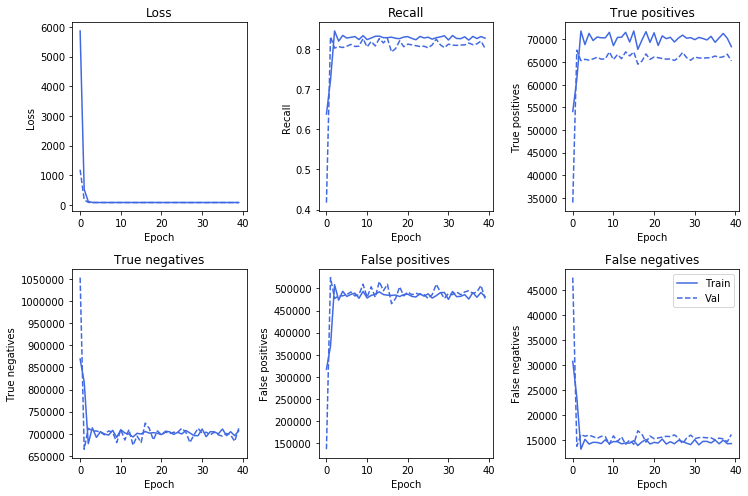

In [29]:
metrics =  ['loss', 'recall', 'true_positives', 'true_negatives', 'false_positives', 'false_negatives']
filename = '../../figures/parallel_LSTM_learning_curves_CA_only.png'
print(f"Total observations: {len(training_data)}")
plot_metrics(history, metrics, filename)

In [ ]:
training_predictions = model.predict(x_training)
training_ignition_risk_predictions = training_predictions.flatten()
training_true_fires = y_training.flatten()

testing_predictions = model.predict(x_testing)
testing_ignition_risk_predictions = testing_predictions.flatten()
testing_true_fires = y_testing.flatten()

In [ ]:
sns.kdeplot(training_ignition_risk_predictions, cumulative=False, bw=0.01)
plt.xlim(-0.1, 1)
plt.show()

In [ ]:
training_results = model.evaluate(
    x_training,
    y_training 
)

testing_results = model.evaluate(
    x_testing,
    y_testing 
)

In [ ]:
training_results

In [ ]:
for name, value in zip(model.metrics_names, training_results):
    print(name, ': ', value)
    
plot_cm(training_true_fires, training_ignition_risk_predictions)

In [ ]:
for name, value in zip(model.metrics_names, testing_results):
    print(name, ': ', value)
    
plot_cm(testing_true_fires, testing_ignition_risk_predictions)

Mock up some data to match what the live prediction data will look like

In [ ]:
past_history = 5
future_target = 1
step = 1
BATCH_SIZE = 1

x_training, y_training = format_features_labels_for_LSTM(
    training_data,        # incomming_data
    past_history,         # size of past history time chunk
    future_target,        # number of future timepoints to predict from each history time chunk
    step,                 # number of timepoints to move the history time chunk as we slide over the data
)

x_training, y_training = trim_and_reshape_for_LSTM(x_training, y_training)

for i in range(len(x_training)):
    start_index = (x_training[i].shape[0] - (x_training[i].shape[0] % BATCH_SIZE))
    end_index = x_training[i].shape[0]

    x_training[i] = np.delete(x_training[i], range(start_index, end_index), axis=0)

In [ ]:
mock_data = []

for spatial_bin in x_training:
    bin_slice = spatial_bin[0:7,:,]
    mock_data.append(bin_slice)
    
mock_labels = y_training[0:7]
    
print("x_training is {}, length: {}, member shape: {}.".format(type(x_training), len(x_training), x_training[0].shape))
print("y_training is {}, length: {}, member shape: {}.".format(type(y_training), len(y_training), y_training[0].shape))
print("mock_data is {}, length: {}, member shape: {}.".format(type(mock_data), len(mock_data), mock_data[0].shape))
print("mock_labels are {}, length: {}, member shape: {}.".format(type(mock_labels), len(mock_labels), mock_labels[0].shape))

In [ ]:
inputs = []
LSTMs = []

for i in range(len(mock_data)):
    inputs.append(
        keras.Input(
            batch_shape=(
                BATCH_SIZE,
                mock_data[0].shape[1],
                mock_data[0].shape[2]
            )
        )
    )
    
for i in range(len(mock_data)):
    LSTMs.append(keras.layers.LSTM(
        lstm_units,
        dropout = variational_dropout,
        stateful = True
    )(inputs[i]))
    
merged = keras.layers.concatenate(LSTMs)

hidden1 = keras.layers.Dense(
    hidden_units,
    kernel_regularizer=keras.regularizers.l1(hidden_l1_lambda),
    bias_initializer=tf.keras.initializers.he_normal(),
    activation = 'relu'
)(merged)

hidden2 = keras.layers.Dense(
    hidden_units,
    kernel_regularizer=keras.regularizers.l1(hidden_l1_lambda),
    bias_initializer=tf.keras.initializers.he_normal(),
    activation = 'relu'
)(hidden1)

output = keras.layers.Dense(
    410,
    activation = 'sigmoid',
    bias_initializer = output_bias
)(hidden2)

production_model = keras.Model(inputs=inputs, outputs=output)

production_model.load_weights('./trained_model_weights/parallel_LSTM_weights.tf')
production_model.summary()

In [ ]:
mock_predictions = production_model.predict(mock_data)
flat_mock_predictions = mock_predictions.flatten()

In [ ]:
sns.kdeplot(flat_mock_predictions, cumulative=False, bw=0.01)
plt.xlim(-0.1, 1)
plt.show()